## Binary data

## Imports and notebook reload

In [333]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

from binaryStatistics.base_distribution import BaseDistribution
from binaryStatistics.distributions import Uniform, Thermal, PowerLaw, Sine, VelTilde, PhiAngle
from binaryStatistics.plot_utils import plot_histogram

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [334]:
from sklearn.model_selection import train_test_split

## Get companions new masses

In [337]:
def get_companions_mass(Mag1, Mag2, label="without"):
    
    def get_kappa(delta_Mag):
        dM = delta_Mag.random_sample(0.01,12,1)
        return 1/(1 + 10**(-0.4*dM))[0]
    
    def get_mass(mag):
        return 10**(0.0725*(4.76 - mag))
    
    gamma = -0.7
    delta_Mag = PowerLaw(
        dist_parameters={
            "C": (1 + gamma)/(12**gamma),
            "alpha": gamma,
        }
    )
    kappa = get_kappa(delta_Mag)
    
    if label == "without":
        return {
            "mass_comp_1": get_mass(Mag1),
            "mass_comp_2": get_mass(Mag2),
        }
    elif label == "more":
        if Mag1 > Mag2:
            host = -2.5*np.log10(kappa) + Mag1
            comp = -2.5*np.log10(1 - kappa) + Mag1
            
            return {
                "mass_comp_1": get_mass(host) + get_mass(comp),
                "mass_comp_2": get_mass(Mag2),
            }
        else:
            host = -2.5*np.log10(kappa) + Mag2
            comp = -2.5*np.log10(1 - kappa) + Mag2
            
            return {
                "mass_comp_1": get_mass(Mag1),
                "mass_comp_2": get_mass(host) + get_mass(comp),
            }
            
    elif label == "less":
        if Mag1 < Mag2:
            host = -2.5*np.log10(kappa) + Mag1
            comp = -2.5*np.log10(1 - kappa) + Mag1
            
            return {
                "mass_comp_1": get_mass(host) + get_mass(comp),
                "mass_comp_2": get_mass(Mag2),
            }
        else:
            host = -2.5*np.log10(kappa) + Mag2
            comp = -2.5*np.log10(1 - kappa) + Mag2
            
            return {
                "mass_comp_1": get_mass(Mag1),
                "mass_comp_2": get_mass(host) + get_mass(comp),
            }
    elif label == "both":
        kappa = get_kappa(delta_Mag)
        host_1 = -2.5*np.log10(kappa) + Mag1
        comp_1 = -2.5*np.log10(1 - kappa) + Mag1
        kappa = get_kappa(delta_Mag)
        host_2 = -2.5*np.log10(kappa) + Mag2
        comp_2 = -2.5*np.log10(1 - kappa) + Mag2
        
        return {
            "mass_comp_1": get_mass(host_1) + get_mass(comp_1),
            "mass_comp_2": get_mass(host_2) + get_mass(comp_2),
        }

## Power law fit

Here we define the function for the Power-Law fit

In [33]:
def power_law(x: float or np.array, C: float, alpha: float) -> np.array:
    """Power law fit.
    
    Parameters:
        x (float or np.array):
            The X independent data to fit.
        
        C (float):
            Proportionality constant.
        
        alpha (float):
            Power-law exponent
        
    Returns:
        The fitted Y dependent data.
    """
    return C * np.power(x, -alpha)

## Binery data read

Since the binary data is stored in a CSV file, the best way to read and manipulate the data is by using the Pandas Library.

In [34]:
## With this line we extract all the data in the file WB450.csv
binary_dataframe = pd.read_csv("../data/667Bp_0.8.csv")

In [35]:
## With this line we print all the labels (columns) presented in our data
binary_dataframe.columns

Index(['Unnamed: 0', 'SOURCE_ID_PRIMARY', 'ra1', 'dec1', 'mag1', 'MAG1',
       'PARALLAX1', 'parallax_error1', 'DIST1', 'RUWE1', 'PMRA1',
       'PMRA_ERROR1', 'PMDEC1', 'PMDEC_ERROR1', 'BminusR1', 'mass_calc1',
       'mass_flame1', 'mass_flame_upper1', 'mass_flame_lower1', 'age_flame1',
       'age_flame_upper1', 'age_flame_lower1', 'PROB1', 'SOURCE_ID_SECONDARY',
       'ra2', 'dec2', 'mag2', 'MAG2', 'PARALLAX2', 'parallax_error2', 'DIST2',
       'RUWE2', 'PMRA2', 'PMRA_ERROR2', 'PMDEC2', 'PMDEC_ERROR2', 'BminusR2',
       'mass_calc2', 'mass_flame2', 'mass_flame_upper2', 'mass_flame_lower2',
       'age_flame2', 'age_flame_upper2', 'age_flame_lower2', 'PROB2', 'DIST',
       'RA_MEAN', 'DEC_MEAN', 'vRA', 'vRAerr', 'vDEC', 'vDECerr', 'V2D',
       'Log10vRA', 'Log10vDEC', 'Log10r', 'r', 'M'],
      dtype='object')

In [36]:
# As we can see here, the `vDECerr` data is not a float but a string 
print(f"vRAerr example: {binary_dataframe['vRAerr'][0]}, a float as needed")
print(f"vDECerr example: {binary_dataframe['vDECerr'][0]}, a tuple, which is not desire")

vRAerr example: 0.0270357787770398, a float as needed
vDECerr example: (0.10233914394539495,), a tuple, which is not desire


In [37]:
# So, we convert all the `vDECerr` column to float data
# The `apply` method runs a function (lambda) over each data in the column.
# The lambda function used here performs a split by "(", take the last element (-1)
# then a split by ",)", take the first element (0). This steps extract the numeric
# value from the string, and finally we convert the result to float.
binary_dataframe["vDECerr"] = binary_dataframe["vDECerr"].apply(lambda x: float(x.split("(")[-1].split(",)")[0]))

## V2D error

The `V2D` label has no error, but the `vRA` and `vDEC` does. So we use those values, and the following formula to compute de `d_V2D` column, which has the `V2D` errors.
$$
dV = \frac{v_x}{V} dv_x + \frac{v_y}{V} dv_y,
$$
where $dV$ is the error in the `V2D` velocity column, $v_x$ is `vRA`, $v_y$ is `vDEC`, $dv_x$ is `vRAerr` and $dv_y$ is `vDECerr`.

In [38]:
binary_dataframe["d_V2D"] = (binary_dataframe["vRA"]/binary_dataframe["V2D"])*binary_dataframe["vRAerr"] + (binary_dataframe["vDEC"]/binary_dataframe["V2D"])*binary_dataframe["vDECerr"]

## Data visualization

Text(0, 0.5, '2D relative velocity (km/s)')

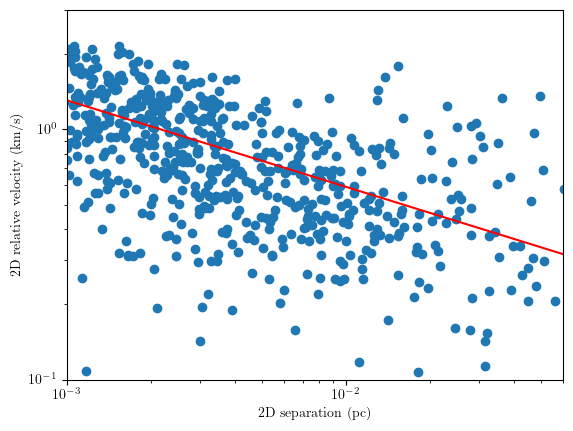

In [39]:
# First, we perform the fit of the power_law function over the data using `r` and `V2D` columns.
# For this, we use the `curve_fit` SciPy function, that returns the best fitted parameters `params`
# and the covariance of this fit.
params, params_covariance = curve_fit(power_law, binary_dataframe["r"], binary_dataframe["V2D"])
C, alpha = params

# Then we plot the data with the fitted power law.

## Initialize figure
fig, ax = plt.subplots()

## Scatter plot of the binaries data.
ax.scatter(binary_dataframe["r"], binary_dataframe["V2D"])

## Linear plot of the power law fit.
x = np.linspace(0.001, 0.06, 1000)
ax.plot(x, power_law(x, C, alpha), color="red")

## Update figure layout
plt.xscale("log")
plt.yscale("log")
ax.set_xlim(0.001,0.06)
ax.set_ylim(0.1,3)
ax.set_xlabel("2D separation (pc)")
ax.set_ylabel("2D relative velocity (km/s)")

# V2D synthetic sample

Now, we create synthetic data by using the 2D separtion of the actual data (`r` column) and a synthetic
value of `V2D` that we are going to label as `synV2D`.

In [40]:
# Define G gravitational constant
G = 4.3009e-03 # pc·(km/s)²·M_\odot⁻¹

In [41]:
# Set the size of the data to simulate, base on the lenght of the 2D separation data.
data_length = len(binary_dataframe["r"])

In order to simulate the `V2D` data, we use the equation:
$$
v_{2D} = \sqrt{\frac{GM}{r_{2D}}} \tilde{v},
$$
where
$$
\tilde{v}\left( \phi, \phi_0, i, e \right) = \sqrt[4]{1 - \sin^2 i \cos^2 \left( \phi - \phi_0 \right)} \sqrt{\frac{1 + e^2 + 2e\cos\phi - \sin^2 i \left( e\sin\phi_0 - \sin \left( \phi - \phi_0 \right) \right)}{1 - e\cos\phi}},
$$
and where $\phi$ is the phase angle, $\phi_0$ is the initial phase_angle, $i$ is the orbital angle projection and $e$ is the orbit eccentricity.

In order to get a random distribution of $\tilde{v}\left( \phi, \phi_0, i, e \right)$ for the synthetic data, we need to create distributions for all the variables $\phi$, $\phi_0$, $i$ and $e$.

### Initial phase angle $\phi_0$

The initial phase angle follows a uniform distribution between 0 and $2\pi$.
$$
p_{\phi_0} \left(\phi_0\right) = \mathcal{U} \left\lbrace 0, 2\pi \right\rbrace
$$

In [42]:
uniform = Uniform()
phi_0 = uniform.random_sample(0,2*np.pi,size=data_length)

### Eccentricity $e$

The orbit eccentricity follows a thermal distribution between 0 and 1.
$$
p_e(e) = 2e
$$

In [43]:
thermal = Thermal()
e = thermal.random_sample(0,1,size=data_length)

### Orbital projection angle $i$

The orbital projection angle follows a distribution between 0 and $\pi/2$ of the form:
$$
p_i(i) = \sin(i)
$$

In [44]:
sine = Sine()
i = sine.random_sample(0,np.pi/2,size=data_length)

### Phase angle $\phi$

And, finally, the phase angle follows a distribution between 0 and $2\pi$ of the form:
$$
p_\phi \left( \phi | e \right) = \frac{\left( 1 - e^2\right)^{3/2}}{2\pi \left( 1 + e \cos\phi \right)^2},
$$

In [45]:
phi_angle = PhiAngle(
    dist_parameters={
        "e": e,
    }
)
phi = phi_angle.random_sample(0,2*np.pi,size=data_length)

### Dimensionless velocity $\tilde{v}\left( \phi, \phi_0, i, e \right)$

And now, we can compute the distribution for the dimensionless velocity $\tilde{v}$

In [46]:
vel = VelTilde()
v_tilde = vel.distribution(phi, phi_0, i, e)

We now visualize the distribution

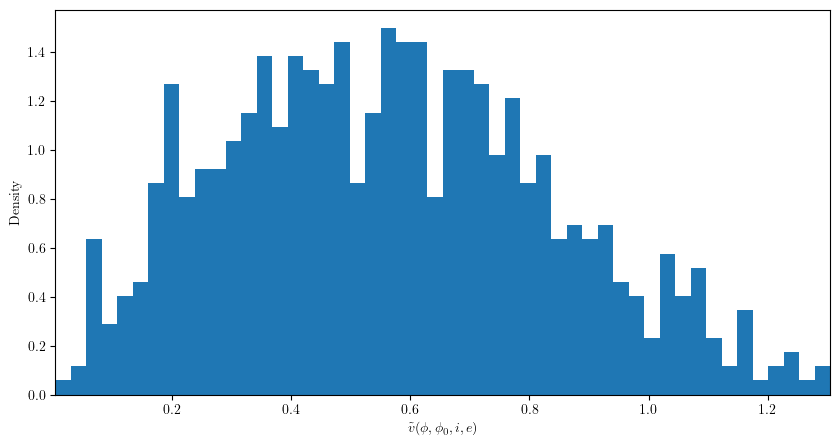

In [47]:
fig, ax = plot_histogram(
    v_tilde,
    bins=50,
    density=True,
    x_params={
        "label":"$\\tilde{v}(\\phi, \\phi_0, i, e)$",
    },
)

And compare it with the computed with high resolution

In [48]:
## Extract data with the high resolution \tilde{v} distribution
with open("../data/VTil.dat","r") as file:
    lines = file.readlines()
    
    v = []
    v_dist = []
    for line in lines:
        vel, dist = line.strip().split(" ")
        v.append(float(vel))
        v_dist.append(float(dist))

And visualize them together

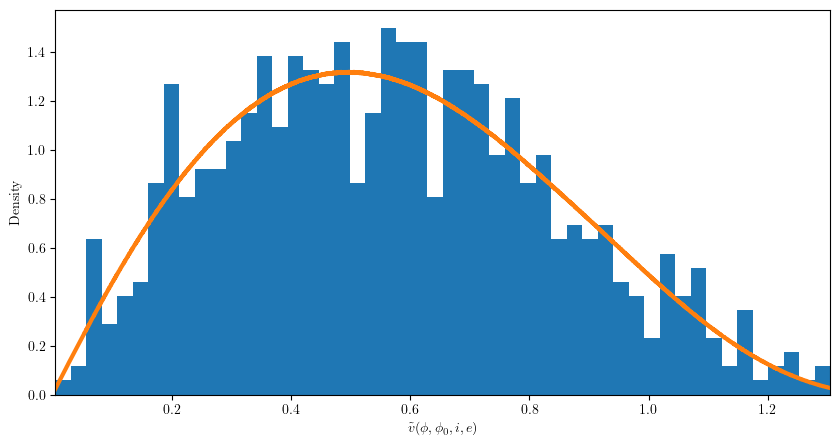

In [49]:
fig, ax = plot_histogram(
    v_tilde,
    bins=50,
    density=True,
    x_params={
        "label":"$\\tilde{v}(\\phi, \\phi_0, i, e)$",
    },
)
ax.plot(v, v_dist, linewidth=3)

## Synthetic $v_{2D}$

Now, using the simulated distribution for $\tilde{v}$ we can compute the synthetic data for $v_{2D}$ (`synV2D`)

In [50]:
term = np.sqrt(G*binary_dataframe["M"]/binary_dataframe["r"])
binary_dataframe["synV2D"] = term*v_tilde #+ df["d_V2D"]*np.random.uniform(-1,1)

And, we visualize the synthetic data

Text(0, 0.5, '2D relative velocity (km/s)')

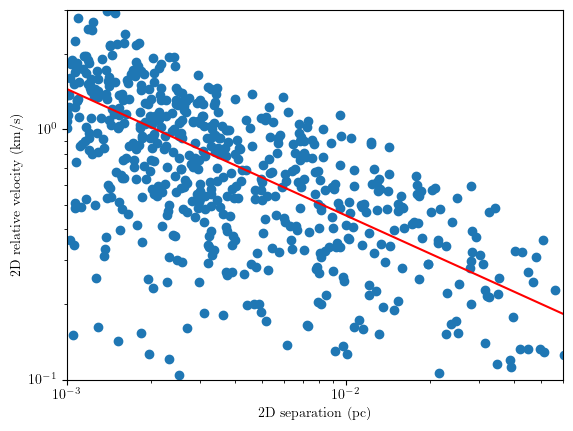

In [51]:
# First, we perform the fit of the power_law function over the data using `r` and `V2D` columns.
# For this, we use the `curve_fit` SciPy function, that returns the best fitted parameters `params`
# and the covariance of this fit.
params, params_covariance = curve_fit(power_law, binary_dataframe["r"], binary_dataframe["synV2D"])
C, alpha = params

# Then we plot the data with the fitted power law.

## Initialize figure
fig, ax = plt.subplots()

## Scatter plot of the binaries data.
ax.scatter(binary_dataframe["r"], binary_dataframe["synV2D"])

## Linear plot of the power law fit.
x = np.linspace(0.001, 0.06, 1000)
ax.plot(x, power_law(x, C, alpha), color="red")

## Update figure layout
plt.xscale("log")
plt.yscale("log")
ax.set_xlim(0.001,0.06)
ax.set_ylim(0.1,3)
ax.set_xlabel("2D separation (pc)")
ax.set_ylabel("2D relative velocity (km/s)")

We can also plot both the real and simulated that at the same time:

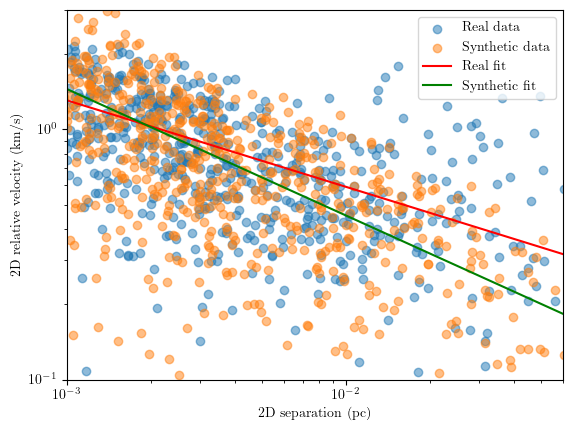

In [52]:
## Initialize figure
fig, ax = plt.subplots()

## Scatter plot of the binaries data.
ax.scatter(binary_dataframe["r"], binary_dataframe["V2D"], alpha=0.5, label="Real data")
ax.scatter(binary_dataframe["r"], binary_dataframe["synV2D"], alpha=0.5, label="Synthetic data")

## Linear plot of the power law fit.
params, params_covariance = curve_fit(power_law, binary_dataframe["r"], binary_dataframe["V2D"])
C, alpha = params
x = np.linspace(0.001, 0.06, 1000)
ax.plot(x, power_law(x, C, alpha), color="red", label="Real fit")
params, params_covariance = curve_fit(power_law, binary_dataframe["r"], binary_dataframe["synV2D"])
C, alpha = params
x = np.linspace(0.001, 0.06, 1000)
ax.plot(x, power_law(x, C, alpha), color="green", label="Synthetic fit")

## Update figure layout
plt.xscale("log")
plt.yscale("log")
ax.set_xlim(0.001,0.06)
ax.set_ylim(0.1,3)
ax.set_xlabel("2D separation (pc)")
ax.set_ylabel("2D relative velocity (km/s)")
plt.legend()

## Including mass of hidden companions

According with Chae (2023), in order to consider the presence of hidden tertiaries companions, we first assume that 40\% of the dataset has at least one main star with companion. From this subset, we can compute the new mass based on the absolute magnitude of the components, and the magnitude difference between them.

Suppose that the host and the hidden companion have relative luminosities of $\kappa$ and $1 - \kappa$, respectively. Then, their absolute magnitudes are
$$
M_{G,h} = -2.5 \log_{10} \kappa + M_G, \\
M_{G,c} = -2.5 \log_{10} ( 1 - \kappa ) + M_G,
$$
where $h$ and $c$ subscripts refer to the host and the companion, and $M_G$ is the absolute magnitude of the whole component that is assumed to have a hidden companion. 

The factor $\kappa$ is related to the magnitude difference between the host and companion as follows:
$$
\kappa = \frac{1}{1 + 10^{(-0.4 \Delta M_G)}},
$$
where $\Delta M_G = M_{G,c}  M_{G,h}$, and its assigned using a power-law probability distribution
$$
p(\Delta M_G; \gamma_M) = (1 + \gamma_M) \left( \frac{\Delta M_G}{12} \right)^{\gamma_M},
$$
where $0 \leq \Delta M_G \leq 12$ and $\gamma_M \approx -0.7$.

In order to compute the new total mass that consider the hidden companions:

1. Split the CSV dataset into a 40\% with companion(s) and 60\% without companion(s)

In [335]:
bd_without_comp, bd_with_comp = train_test_split(binary_dataframe, test_size=0.4, train_size=0.6)

2. The 40\% with companion is splitted into 30\% binaries where both components have hidden companions, and 70\% where only one does. 

In [336]:
bd_with_comp_one, bd_with_comp_both = train_test_split(bd_with_comp, test_size=0.3, train_size=0.7)

3. Finally, this remaining 70\% is splitted into a 30\% where the companion is in the component with less luminosity, and 40\% where the companion is in the component of greater luminosity.

In [338]:
bd_with_comp_more, bd_with_comp_less = train_test_split(bd_with_comp_one, test_size=0.3/0.7, train_size=0.4/0.7)

4. Using Pandas' apply method, we can apply the `get_companions_mass` functions to obtain the new columns `mass_comp_1` and `mass_comp_2`. This columns contain the mass of the component (1 and 2) plus the mass of the hidden companion, if it is the case. 

In [339]:
bd_without_comp[["mass_comp_1", "mass_comp_2"]] = bd_without_comp.apply(lambda x: get_companions_mass(x.MAG1, x.MAG2, label="without"), axis=1, result_type='expand')

In [340]:
bd_with_comp_both[["mass_comp_1", "mass_comp_2"]] = bd_with_comp_both.apply(lambda x: get_companions_mass(x.MAG1, x.MAG2, label="both"), axis=1, result_type='expand')

In [341]:
bd_with_comp_more[["mass_comp_1", "mass_comp_2"]] = bd_with_comp_more.apply(lambda x: get_companions_mass(x.MAG1, x.MAG2, label="more"), axis=1, result_type='expand')

In [342]:
bd_with_comp_less[["mass_comp_1", "mass_comp_2"]] = bd_with_comp_less.apply(lambda x: get_companions_mass(x.MAG1, x.MAG2, label="less"), axis=1, result_type='expand')

5. We concatenate these dataframes into a `new_binary_dataframe` that contains the same data plus the new columns. We also compute the new total mass in `new_M`.

In [343]:
new_binary_dataframe = pd.concat([bd_without_comp, bd_with_comp_both, bd_with_comp_more, bd_with_comp_less])
new_binary_dataframe["new_M"] = new_binary_dataframe["mass_comp_1"] + new_binary_dataframe["mass_comp_2"]

Now, we can visualize the distributions of the total mass before (orange) and after (blue) considering the presence of hidden companions

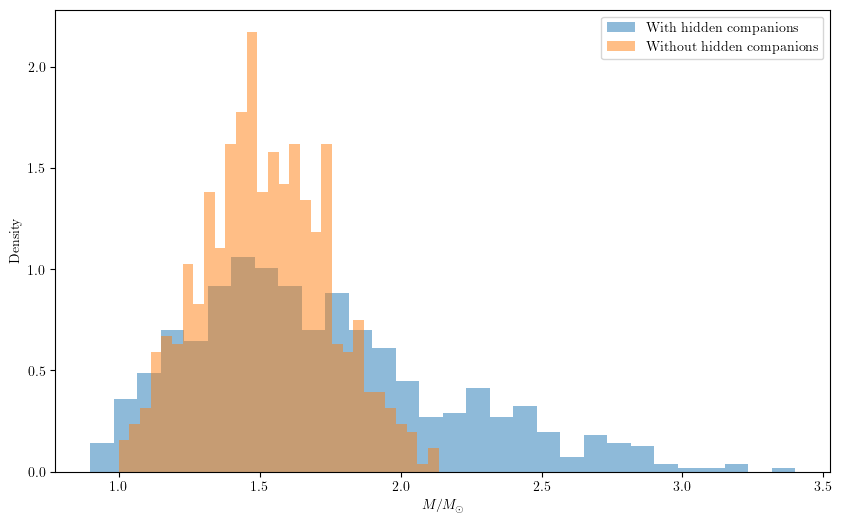

In [325]:
fig, ax = plt.subplots(figsize=(10,6))
_=ax.hist(new_binary_dataframe["new_M"], bins=30, density=True, alpha=0.5, label="With hidden companions")
_=ax.hist(new_binary_dataframe["M"], bins=30, density=True, alpha=0.5, label="Without hidden companions")
ax.set_ylabel("Density")
ax.set_xlabel(r"$M/M_\odot$")
ax.legend()

In [328]:
term = np.sqrt(G*new_binary_dataframe["new_M"]/new_binary_dataframe["r"])
new_binary_dataframe["synV2D"] = term*v_tilde #+ df["d_V2D"]*np.random.uniform(-1,1)

And, we visualize the synthetic data

Text(0, 0.5, '2D relative velocity (km/s)')

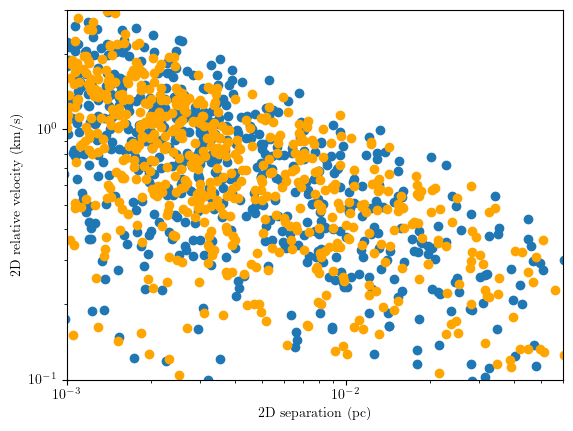

In [330]:
# First, we perform the fit of the power_law function over the data using `r` and `V2D` columns.
# For this, we use the `curve_fit` SciPy function, that returns the best fitted parameters `params`
# and the covariance of this fit.

# Then we plot the data with the fitted power law.

## Initialize figure
fig, ax = plt.subplots()

## Scatter plot of the binaries data.
params, params_covariance = curve_fit(power_law, new_binary_dataframe["r"], new_binary_dataframe["synV2D"])
C, alpha = params
x = np.linspace(0.001, 0.06, 1000)
ax.scatter(new_binary_dataframe["r"], new_binary_dataframe["synV2D"])
#ax.plot(x, power_law(x, C, alpha), color="red")

params, params_covariance = curve_fit(power_law, binary_dataframe["r"], binary_dataframe["synV2D"])
C, alpha = params
x = np.linspace(0.001, 0.06, 1000)
ax.scatter(binary_dataframe["r"], binary_dataframe["synV2D"], color="orange")
#ax.plot(x, power_law(x, C, alpha), color="green")

## Linear plot of the power law fit.

## Update figure layout
plt.xscale("log")
plt.yscale("log")
ax.set_xlim(0.001,0.06)
ax.set_ylim(0.1,3)
ax.set_xlabel("2D separation (pc)")
ax.set_ylabel("2D relative velocity (km/s)")